# IDEA: Bound KL divergence to policy update, like TRPO

# Deep PILCO: Pendulum-v0

### TODO: Policy: turn on std if having working algorithm

In [1]:
%load_ext autoreload
%autoreload 2  # Reload all modules each time before executing Python code

import gym
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from data import rollout, DataBuffer
from model import RandomPolicy, LinearPolicy, MLPPolicy, DynamicsModel, TrueDynamics
from model_utils import optimize_policy, learn_policy, train_dynamics_model, cost
from utils import plot_databuffer, plot_trajectories, plot_dynamics_uncertainty, plot_actions, test_episodic_reward

In [2]:
# Set up environment
env = gym.make('CartPoleSwingUp-v0')

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

[123]

# Testing for training good controller

In [3]:
data = DataBuffer(env)

T = 25

# Create policy and its optimizer
#policy = LinearPolicy(env).cuda()
policy = MLPPolicy(env, hidden_size=100).cuda()
policy_optimizer = optim.Adam(policy.parameters(), lr=5e-5)

for param in policy.parameters():
    nn.init.normal(param, mean=0, std=1e-2)

random_policy = RandomPolicy(env)

# Create dynamics and its optimizer
dynamics = DynamicsModel(env, hidden_size=200, drop_prob=0.05).cuda()
dynamics_optimizer = optim.Adam(dynamics.parameters(), lr=1e-3, weight_decay=1e-4)

for param in dynamics.parameters():
    nn.init.normal(param, mean=0, std=1e-3)

In [4]:
data.push(rollout(env, random_policy, T=T, mode='System'))

(250, 9)


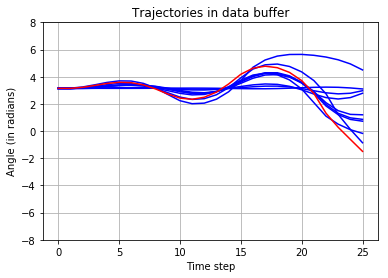

In [39]:
data.max_trajectory = 10

# Put in data and visualize whole data 
data.push(rollout(env, policy, T=T, mode='System'))

print(data.data.shape)

plot_databuffer(data, ylim=[-8, 8])

	[Epoch #   1 (0.3 s)] Train loss: 0.79166227
	[Epoch # 1001 (0.3 s)] Train loss: 0.08776536
	[Epoch # 2000 (0.4 s)] Train loss: 0.05644854

Finished training dynamics model. 



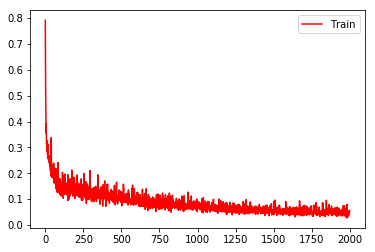

In [35]:
# Train dynamics

dynamics.set_sampling(sampling=False)
for param in dynamics.parameters():
    nn.init.normal(param, mean=0, std=1e-3)

train_losses = train_dynamics_model(dynamics, dynamics_optimizer, data, epochs=2000, batch_size=data.data.shape[0]//100)
#train_losses = train_dynamics_model(dynamics, dynamics_optimizer, data, epochs=2500, batch_size=100)
loss_fig = plt.figure()
plt.plot(train_losses, 'red', label='Train')
plt.legend()
plt.show()
#loss_fig.savefig('loss_Adam.png')

In [26]:
#dynamics = TrueDynamics(env).cuda()

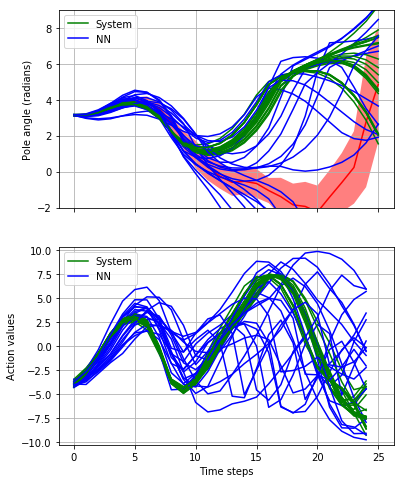

In [43]:
# Plot trajectory to compare system and NN dynamics
fig = plot_trajectories(env, policy, policy_optimizer, dynamics, N=20, T=T, predict_uncertainty=True, ylim=[-2, 9])
fig

In [37]:
# Turn off gradient computation of dynamics model
#for param in dynamics.parameters():
#    param.requires_grad = False

# Update policy
num_policy_iter = 1000
log_interval = 100
for i in range(num_policy_iter):
    policy, list_costs, list_moments = learn_policy(env, dynamics, policy, policy_optimizer, K=30, T=T, 
                                                    gamma=1.0, moment_matching=True, 
                                                    c_sigma=0.25)

    #optimize_policy(list_costs, dynamics, policy, policy_optimizer)
      
    if (i + 1)%log_interval == 1 or (i + 1) == num_policy_iter:
        log_str = '[Mean cost # {:3d}]: {:.6f}, \t Grad norm: {:.6f}'
        print(log_str.format(i+1, 
                             np.mean([c.data.cpu().numpy()[0] for c in list_costs]),
                             np.linalg.norm(next(policy.parameters()).grad.data.cpu().numpy()[0])))
        print('\t Grad of policy: ', next(policy.parameters()).grad.data.cpu().numpy()[0])
        print('\t Param of policy: ', next(policy.parameters()).data.cpu().numpy()[0])
        print('\t Test rewards: ', test_episodic_reward(env, policy, N=50, T=T, render=False))
        print('\n')

print('Done policy optmization.')

[Mean cost #   1]: 0.936131, 	 Grad norm: 0.253956
	 Grad of policy:  [-0.10681085 -0.19033663 -0.08764352 -0.04437898  0.08488905]
	 Param of policy:  [-0.00555102 -0.0080931   0.02152676 -0.01714228  0.00579849]
	 Test rewards:  -24.8877813803


[Mean cost # 101]: 0.989774, 	 Grad norm: 0.185821
	 Grad of policy:  [ 0.04613211  0.11590639  0.04085243  0.02557217 -0.1290115 ]
	 Param of policy:  [-0.00183018 -0.0067125   0.0235911  -0.01631793  0.00479443]
	 Test rewards:  -24.7325653661


[Mean cost # 201]: 0.988514, 	 Grad norm: 0.146400
	 Grad of policy:  [ 0.03897262  0.08231382  0.02920822  0.00593748 -0.11067987]
	 Param of policy:  [-0.00106867 -0.00608746  0.024773   -0.0154297   0.00411275]
	 Test rewards:  -24.3757696629


[Mean cost # 301]: 0.961794, 	 Grad norm: 0.253216
	 Grad of policy:  [ 0.07170958  0.22795583  0.05022943  0.02608778  0.06171408]
	 Param of policy:  [-0.00022694 -0.0054571   0.02583614 -0.01472868  0.00345449]
	 Test rewards:  -24.1077531482


[Mean co

In [42]:
################### TEST ##########################

for _ in range(50):
    data.max_trajectory = 10

    # Put in data and visualize whole data 
    data.push(rollout(env, policy, T=T, mode='System'))

    # Train dynamics

    dynamics.set_sampling(sampling=False)
    for param in dynamics.parameters():
        nn.init.normal(param, mean=0, std=1e-3)

    train_losses = train_dynamics_model(dynamics, dynamics_optimizer, data, epochs=2000, batch_size=data.data.shape[0]//100)

    # Update policy
    num_policy_iter = 1000
    log_interval = 100
    for i in range(num_policy_iter):
        policy, list_costs, list_moments = learn_policy(env, dynamics, policy, policy_optimizer, K=30, T=T, 
                                                        gamma=1.0, moment_matching=True, 
                                                        c_sigma=0.25)

        #optimize_policy(list_costs, dynamics, policy, policy_optimizer)

        if (i + 1)%log_interval == 1 or (i + 1) == num_policy_iter:
            log_str = '[Mean cost # {:3d}]: {:.6f}, \t Grad norm: {:.6f}'
            print(log_str.format(i+1, 
                                 np.mean([c.data.cpu().numpy()[0] for c in list_costs]),
                                 np.linalg.norm(next(policy.parameters()).grad.data.cpu().numpy()[0])))
            print('\t Grad of policy: ', next(policy.parameters()).grad.data.cpu().numpy()[0])
            print('\t Param of policy: ', next(policy.parameters()).data.cpu().numpy()[0])
            print('\t Test rewards: ', test_episodic_reward(env, policy, N=50, T=T, render=False))
            print('\n')

    print('Done policy optmization.')


	[Epoch #   1 (0.3 s)] Train loss: 0.85424462
	[Epoch # 1001 (0.3 s)] Train loss: 0.05459624
	[Epoch # 2000 (0.3 s)] Train loss: 0.06079469

Finished training dynamics model. 

[Mean cost #   1]: 0.972741, 	 Grad norm: 0.249952
	 Grad of policy:  [ 0.03055405  0.15063128 -0.04184863 -0.18367845  0.05799666]
	 Param of policy:  [ 0.00044852 -0.00459388  0.02855704 -0.01334119  0.00062286]
	 Test rewards:  -24.2879617542


[Mean cost # 101]: 0.895559, 	 Grad norm: 1.379736
	 Grad of policy:  [ 0.16609079  0.52782309  0.11157642  0.38302454 -1.19930387]
	 Param of policy:  [ -2.05337376e-04  -4.81188903e-03   2.93283705e-02  -1.24462983e-02
   5.92251963e-05]
	 Test rewards:  -24.7112959469


[Mean cost # 201]: 0.888311, 	 Grad norm: 0.705260
	 Grad of policy:  [ 0.12639678  0.32250655  0.05713524  0.25950247 -0.55389404]
	 Param of policy:  [-0.00074998 -0.00489658  0.0298312  -0.01170849 -0.00071231]
	 Test rewards:  -24.7627009498


[Mean cost # 301]: 0.847438, 	 Grad norm: 0.273614
	 

In [30]:
import os
from itertools import product

list_seeds = [123]
list_lr_dynamics = [1e-3]
list_lr_policy = [1e-3, 1e-4, 1e-5]
list_p = [0.05, 0.1]
list_num_iter_policy = [100, 500, 1000, 1500]
list_c_sigma = [0.25, 0.15, 0.35, 0.1]

str_path = './log/script.txt'
if os.path.exists(str_path):
    os.remove(str_path)

for lr_dynamics, lr_policy, p, num_iter_policy, seed, c_sigma in product(list_lr_dynamics, list_lr_policy, 
                                                                list_p, list_num_iter_policy, 
                                                                list_seeds, list_c_sigma):
    s = '\'source ~/.bashrc; source activate RL; python script_pendulum.py --seed {:d} --num_iter_policy  {:d}'\
        ' --policy_type MLPPolicy --hidden_size 100 --T 25 --num_iter_algo 30 --lr_dynamics {:f} --lr_policy {:f} --drop_p {:f} --c_sigma {:f}\''
    s = s.format(seed, num_iter_policy, lr_dynamics, lr_policy, p, c_sigma)
    
    with open('./log/script.txt', 'a') as f:
        f.write(s)
        f.write('\n\n')
        
##### cat log/script.txt | xargs -n 1 -P $NUM_CPUS bash -c

In [ ]:
F.selu

In [24]:
rollout(env, policy, T=30, mode='System')

array([[ 2.44346094,  0.        , -1.84555721,  2.48277685,  0.39315899],
       [ 2.48277688,  0.39315897, -1.71751726,  2.56074148,  0.7796463 ],
       [ 2.56074142,  0.77964628, -1.64661479,  2.67013644,  1.09394956],
       [ 2.67013645,  1.09394956, -1.65324104,  2.79683548,  1.26699046],
       [ 2.79683542,  1.26699042, -1.74979997,  2.92082324,  1.23987755],
       [ 2.92082334,  1.23987758, -1.93572545,  3.01899505,  0.98171809],
       [ 3.01899505,  0.98171806, -2.19309902,  3.06938731,  0.50392262],
       [ 3.0693872 ,  0.50392264, -2.48592401,  3.05582846, -0.1355885 ],
       [ 3.05582857, -0.1355885 , -2.76475954,  2.97194441, -0.83884052],
       [ 2.97194433, -0.83884054, -2.97484231,  2.82368458, -1.48259829],
       [ 2.82368469, -1.4825983 , -3.00582767,  2.6314678 , -1.92216774],
       [ 2.63146782, -1.92216778, -2.88370895,  2.42466432, -2.06803485],
       [ 2.42466426, -2.06803489, -2.64075971,  2.23542479, -1.8923953 ],
       [ 2.23542476, -1.89239526, -2.3

In [26]:
rollout(env, policy, dynamics, T=30, mode='NN')

array([[ 2.44346094,  0.        , -1.84555721,  2.48277688,  0.39315921],
       [ 2.48277688,  0.39315921, -1.71751714,  2.56074142,  0.7796464 ],
       [ 2.56074142,  0.7796464 , -1.64661479,  2.67013645,  1.09394932],
       [ 2.67013645,  1.09394932, -1.65324116,  2.79683542,  1.26698971],
       [ 2.79683542,  1.26698971, -1.74980044,  2.9208231 ,  1.23987699],
       [ 2.9208231 ,  1.23987699, -1.93572545,  3.01899481,  0.98171723],
       [ 3.01899481,  0.98171723, -2.19309902,  3.06938696,  0.50392234],
       [ 3.06938696,  0.50392234, -2.48592353,  3.05582809, -0.13558787],
       [ 3.05582809, -0.13558787, -2.76475811,  2.97194409, -0.83883941],
       [ 2.97194409, -0.83883941, -2.97484136,  2.82368445, -1.48259664],
       [ 2.82368445, -1.48259664, -3.00582671,  2.63129306, -1.92391407],
       [ 2.63129306, -1.92391407, -2.88405657,  2.4243269 , -2.06966114],
       [ 2.4243269 , -2.06966114, -2.64083576,  2.23495984, -1.8936702 ],
       [ 2.23495984, -1.8936702 , -2.3

In [36]:
init_particle = np.array([1., 8.])
init_particle

array([ 1.,  8.])

In [45]:
data.push(rollout(env, policy.cuda(), dynamics.cuda(), T=10, mode='NN', init_particle=init_particle))

In [ ]:
data[0]

In [28]:
list_costs, list_moments = predict_trajectories(env, dynamics, policy, K=10, T=10)
torch.cat(list_costs).mean().data.cpu().numpy()

array([ 0.34167325], dtype=float32)

In [40]:
import time
import gym
import numpy as np
from model import LinearPolicy
import torch
from torch.autograd import Variable


env = gym.make('CartPoleSwingUp-v0')
s = env.reset()

for _ in range(25):
    s = Variable(torch.FloatTensor(env.unwrapped.state).cuda()).unsqueeze(0)
    a = policy(s)
    env.step(a.data.cpu().numpy())
    
    env.render()
    
    time.sleep(0.2)

In [32]:
K = 10
particles = Variable(torch.FloatTensor([env.reset() for _ in range(K)])).cuda()

# t = 1
actions = policy(particles)
state_actions = torch.cat([particles, actions.unsqueeze(1)], 1)
next_states = dynamics(state_actions)
costs = torch.mean(cost(next_states, sigma=0.25))
costs

Variable containing:
 0.9208
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [37]:
actions = policy(next_states)
state_actions = torch.cat([next_states, actions.unsqueeze(1)], 1)
next_states = dynamics(state_actions)
costs2 = torch.mean(cost(next_states, sigma=0.25))
costs2

Variable containing:
 0.9690
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [45]:
for param in policy.parameters():
    print(param)

Parameter containing:
 0.2682  0.2657
-0.0592  0.0095
 0.3160  0.1810
 0.2785  0.2600
 0.2476 -0.0824
 0.2763  0.0671
-0.0704 -0.0035
 0.2449 -0.0839
 0.2980  0.1486
-0.0434 -0.0011
-0.0868  0.0083
-0.0607  0.0076
 0.1433 -0.0717
-0.0461 -0.0088
 0.2501 -0.0299
 0.2608  0.0325
-0.0105  0.0042
 0.2511 -0.0209
-0.0875  0.0011
 0.2469 -0.1327
-0.0659  0.0113
-0.0633  0.0029
-0.0278 -0.0028
-0.0468 -0.0040
 0.2182  0.2074
-0.0554 -0.0048
 0.2966  0.1772
 0.2490 -0.1198
-0.0812  0.0046
 0.2455 -0.0925
-0.0448  0.0004
 0.2855  0.2259
-0.0840 -0.0013
 0.3149  0.1106
 0.3142  0.1916
-0.0522  0.0021
-0.0567  0.0034
 0.2482 -0.0861
 0.2806  0.1627
-0.0833  0.0029
 0.2739  0.1122
 0.2682  0.0360
-0.0767  0.0071
 0.2450 -0.0727
 0.2104  0.1200
-0.0419 -0.0068
-0.0796  0.0034
 0.2501 -0.0969
-0.0549  0.0071
-0.0561 -0.0036
-0.0459  0.0117
 0.2480 -0.0307
-0.0248  0.1985
 0.2644  0.0619
 0.2621  0.0331
-0.0661 -0.0074
-0.0694 -0.0041
 0.2268  0.2891
-0.0416 -0.0024
 0.2667  0.2273
 0.2437 -0.0946
 0

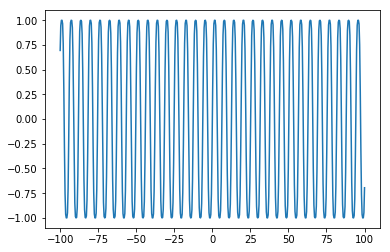

In [29]:
def f(x):
    return 9/8*np.sin(x) + 1/8*np.sin(3*x)

x = np.linspace(-100, 100, 500)
plt.plot(x, f(x))
plt.show()